In [12]:
import os
import numpy as np
import cv2
import openslide
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

In [14]:
IHC_SLIDE_PATH = "D:/data/images/test/25P7216_6_2_IHC.mrxs"
# -----------------------------
# PARAMETERS
# -----------------------------
WSI_DIR = "D:/data/images/bloc/"
OUTPUT_DIR = "D:/data/patching_ihc_kmeans_2_60_tissue/"
PATCH_SIZE = 224
LEVEL = 0
TISSUE_THRESHOLD = 0.60 #OpenMidnight Threshold 
KMEANS = True
SAVE_MASKED_PATCHES = False

os.makedirs(OUTPUT_DIR, exist_ok=True)


# Slide Level Tests

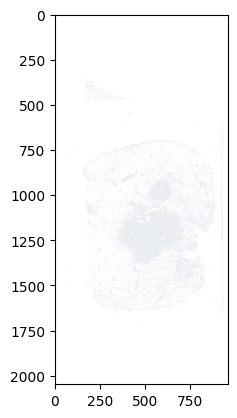

In [3]:
slide = openslide.OpenSlide(IHC_SLIDE_PATH)
x,y = slide.dimensions

img = slide.get_thumbnail(tuple([2048,2048]))
#Kmeans method
slide_array = np.array(img)
flattened = slide_array.reshape((-1, 3))

# convert to float 32
flattened = np.float32(flattened)

        # k means clustering
ret, label, center = cv2.kmeans(flattened, 2, None
, (cv2.TERM_CRITERIA_MAX_ITER + cv2.TERM_CRITERIA_EPS, 10, 1)
, 10, cv2.KMEANS_RANDOM_CENTERS)
# convert back to unint8 and assemble image
center = np.uint8(center)
res = center[label.flatten()]
res2 = res.reshape((slide_array.shape))


plt.imshow(res2)

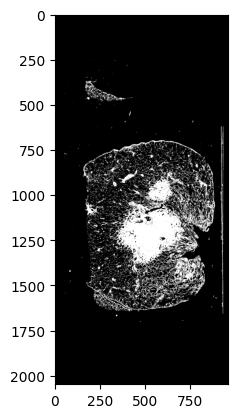

In [7]:

# center shape: (3, 3) -> RGB centers
brightness = center.sum(axis=1)

# index of whitest cluster
white_cluster = np.argmax(brightness)
labels_2d = label.reshape(slide_array.shape[:2])
white_mask = (labels_2d == white_cluster)
# Convert to RGBA
res2_rgba = np.dstack([res2, np.full(res2.shape[:2], 255, dtype=np.uint8)])
black_mask = ~white_mask



plt.imshow(black_mask, cmap='gray')

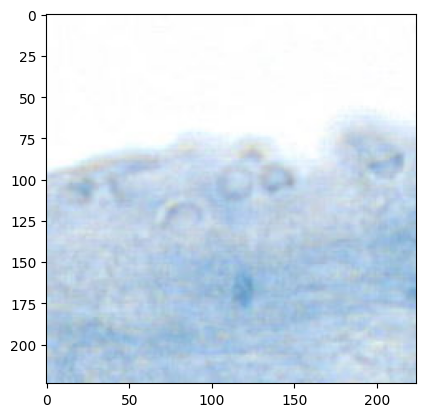

In [8]:
patch = cv2.imread('D:/data/patching_IHC_v0/x56224_y126336_patch_75_25P7216_6_2_IHC.png')
patch = cv2.cvtColor(patch, cv2.COLOR_BGR2RGB)

def assign_pixels_to_clusters(patch, centers):
    """
    patch:   np.ndarray of shape (224, 224, 3), dtype uint8 or float
    centers: np.ndarray of shape (K, 3)
    
    returns:
        cluster_map: (224*224, 1) array of cluster indices
    """
    # Flatten pixels -> (N, 3), where N = 224*224
    pixels = patch.reshape(-1, 3).astype(np.float32)
    centers = np.asarray(centers, dtype=np.float32)
    
    # Compute squared distances: (N, K)
    diff = pixels[:, None, :] - centers[None, :, :]
    distances_sq = np.sum(diff ** 2, axis=2)
    
    # Nearest cluster for each pixel
    labels = np.argmin(distances_sq, axis=1)
    
    # Return as column vector
    return labels.reshape(-1, 1)
plt.imshow(patch)


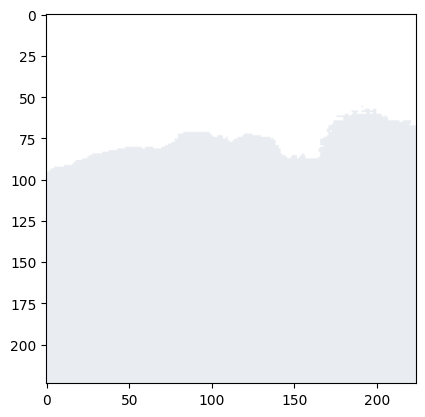

In [9]:
label = assign_pixels_to_clusters(patch,center)
res = center[label.flatten()]
res2 = res.reshape((patch.shape))

plt.imshow(res2)


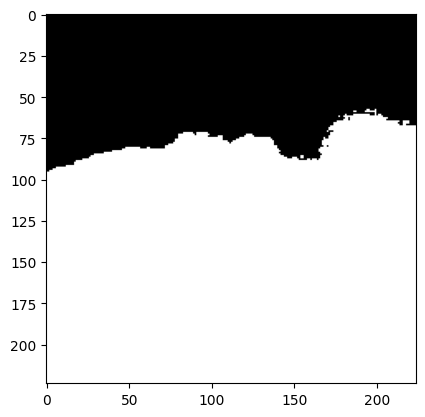

In [ ]:
# center shape: (3, 3) -> RGB centers
brightness = center.sum(axis=1)

# index of whitest cluster
white_cluster = np.argmax(brightness)
labels_2d = label.reshape(patch.shape[:2])
white_mask = (labels_2d == white_cluster)
# Convert to RGBA
res2_rgba = np.dstack([res2, np.full(res2.shape[:2], 255, dtype=np.uint8)])
black_mask = ~white_mask



plt.imshow(black_mask, cmap='gray')


In [24]:
patch = slide.read_region(
                (56224, 126336),
                LEVEL,
                (PATCH_SIZE, PATCH_SIZE)
            )
patch2 = slide.read_region(
                (224, 224),
                LEVEL,
                (PATCH_SIZE, PATCH_SIZE)
            )

# Slide Level (CODE)

In [4]:

# -----------------------------
# Kmeans functions
# -----------------------------

def get_color_clusters(slide: openslide.OpenSlide, k: int):
    img = slide.get_thumbnail(tuple([2048,2048]))
    #Kmeans method
    slide_array = np.array(img)
    flattened = slide_array.reshape((-1, 3))

    # convert to float 32
    flattened = np.float32(flattened)

    # k means clustering
    ret, label, center = cv2.kmeans(flattened, k, None
    , (cv2.TERM_CRITERIA_MAX_ITER + cv2.TERM_CRITERIA_EPS, 10, 1)
    , 10, cv2.KMEANS_RANDOM_CENTERS)
    # convert back to unint8 and assemble image
    center = np.uint8(center)

    return center

def assign_pixels_to_clusters(patch, centers):
    """
    patch:   np.ndarray of shape (224, 224, 3), dtype uint8 or float
    centers: np.ndarray of shape (K, 3)
    
    returns:
        cluster_map: (224*224, 1) array of cluster indices
    """
    # Flatten pixels -> (N, 3), where N = 224*224
    pixels = patch.reshape(-1, 3).astype(np.float32)
    centers = np.asarray(centers, dtype=np.float32)
    
    # Compute squared distances: (N, K)
    diff = pixels[:, None, :] - centers[None, :, :]
    distances_sq = np.sum(diff ** 2, axis=2)
    
    # Nearest cluster for each pixel
    labels = np.argmin(distances_sq, axis=1)
    
    # Return as column vector
    return labels.reshape(-1, 1)
    

In [5]:

# -----------------------------
# TISSUE MASK FUNCTIONS
# -----------------------------
def compute_tissue_mask_kmeans(center, rgb_img):
        np_patch = np.array(rgb_img)
        # center shape: (3, 3) -> RGB centers
        brightness = center.sum(axis=1)

        # index of whitest cluster
        white_cluster = np.argmax(brightness)
        label = assign_pixels_to_clusters(np_patch,center)
        labels_2d = label.reshape(np_patch.shape[:2])
        white_mask = (labels_2d == white_cluster)
        tissue_mask = ~white_mask


        return tissue_mask

def black_to_white(img):
    """
    img: np.ndarray of shape (H, W, 3), dtype uint8
    returns: np.ndarray with black pixels replaced by white
    """
    # Create a mask of all black pixels
    mask = np.all(img == 0, axis=2)  # shape (H, W), True where pixel is black
    
    # Replace black pixels with white
    img[mask] = [255, 255, 255]
    
    return img

In [15]:
# -----------------------------
# PROCESS ALL WSI FILES
# -----------------------------
wsi_files = [
    f for f in os.listdir(WSI_DIR)
    if f.lower().endswith("ihc.mrxs")
]


print(f"Found {len(wsi_files)} WSI files")

for wsi_file in wsi_files:
    wsi_path = os.path.join(WSI_DIR, wsi_file)
    wsi_name = os.path.splitext(wsi_file)[0]

    print(f"\nProcessing {wsi_file}")
    slide = openslide.OpenSlide(wsi_path)
    width, height = slide.level_dimensions[LEVEL]
    patch_id = 0
    if KMEANS :
        center = get_color_clusters(slide,k=2)

    for y in tqdm(range(0, height - PATCH_SIZE, PATCH_SIZE), desc=wsi_name):
        for x in range(0, width - PATCH_SIZE, PATCH_SIZE):

            patch = slide.read_region(
                (x, y),
                LEVEL,
                (PATCH_SIZE, PATCH_SIZE)
            ).convert("RGB")
            
            patch_np = np.array(patch)
            patch_np = black_to_white(patch_np)
            tissue_mask = compute_tissue_mask_kmeans(center,patch_np)
            tissue_ratio = tissue_mask.mean()
            if tissue_ratio >= TISSUE_THRESHOLD:

                if SAVE_MASKED_PATCHES:
                    masked_patch = patch_np.copy()
                    masked_patch[tissue_mask == 0] = 0

                    out_name_masked = (
                        f"x{x}_y{y}_patch_{patch_id}_{wsi_name}_masked.png"
                    )
                    out_path_masked = os.path.join(OUTPUT_DIR, out_name_masked)

                    Image.fromarray(masked_patch).save(out_path_masked)
                
                
                out_name = (
                        f"x{x}_y{y}_patch_{patch_id}_{wsi_name}.png"
                    )
                out_path = os.path.join(OUTPUT_DIR, out_name)

                Image.fromarray(patch_np).save(out_path)
                

                patch_id += 1

    slide.close()

print("\nAll WSIs processed.")


Found 8 WSI files

Processing 25P13027_5_2_2_IHC.mrxs


25P13027_5_2_2_IHC: 100%|██████████| 1007/1007 [10:41:06<00:00, 38.20s/it]      



Processing 25P16493_8_2_4_IHC.mrxs


25P16493_8_2_4_IHC:  30%|██▉       | 299/1007 [16:45<39:40,  3.36s/it]  


KeyboardInterrupt: 

In [11]:
wsi_files = [
    f for f in os.listdir(WSI_DIR)
    if f.lower().endswith("ihc.mrxs")
]

wsi_files

['25P7216_6_2_IHC.mrxs']

# Patch Level Tries

In [ ]:
# -----------------------------
# PARAMETERS
# -----------------------------
WSI_DIR = "D:/data/images/test"
OUTPUT_DIR = "D:/data/test_patching_no_aug_kmeans_4_threshold_20/"
PATCH_SIZE = 224
LEVEL = 0
TISSUE_THRESHOLD = 0.60 #OpenMidnight Threshold
SAVE_MASKED_PATCHES = False
AUGMENT_IMAGE = False

os.makedirs(OUTPUT_DIR, exist_ok=True)

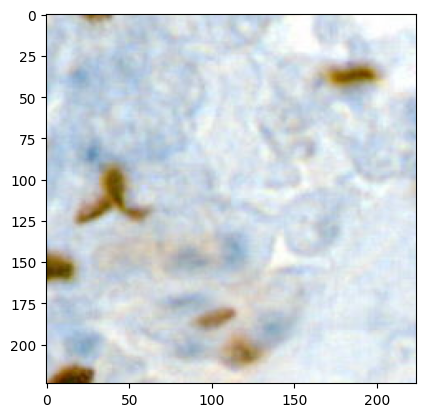

In [ ]:
#Base Image
patch = cv2.imread('D:/data/test_patching_no_aug/x55776_y153664_patch_101_25P7216_6_2_IHC.png')
patch = cv2.cvtColor(patch, cv2.COLOR_BGR2RGB)
plt.imshow(patch)

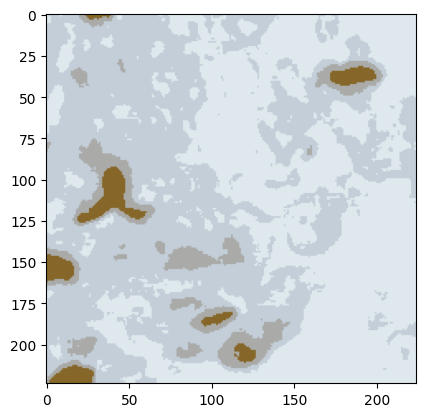

In [ ]:
#Kmeans method

flattened = patch.reshape((-1, 3))

# convert to float 32
flattened = np.float32(flattened)

        # k means clustering
ret, label, center = cv2.kmeans(flattened, 4, None
, (cv2.TERM_CRITERIA_MAX_ITER + cv2.TERM_CRITERIA_EPS, 10, 1)
, 10, cv2.KMEANS_RANDOM_CENTERS)
# convert back to unint8 and assemble image
center = np.uint8(center)
res = center[label.flatten()]
res2 = res.reshape((patch.shape))


plt.imshow(res2)

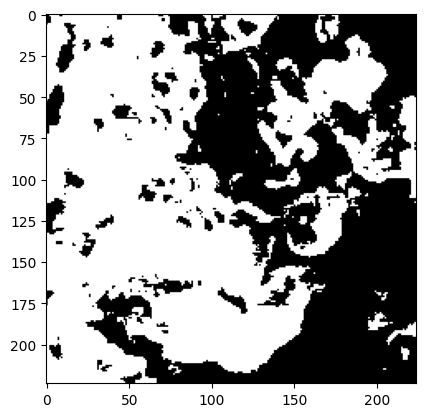

In [ ]:

# center shape: (3, 3) -> RGB centers
brightness = center.sum(axis=1)

# index of whitest cluster
white_cluster = np.argmax(brightness)
labels_2d = label.reshape(patch.shape[:2])
white_mask = (labels_2d == white_cluster)
# Convert to RGBA
res2_rgba = np.dstack([res2, np.full(res2.shape[:2], 255, dtype=np.uint8)])
black_mask = ~white_mask



plt.imshow(black_mask, cmap='gray')

In [ ]:
ratio = black_mask.mean()
print(ratio > TISSUE_THRESHOLD)


True


In [ ]:

# -----------------------------
# TISSUE MASK FUNCTION
# -----------------------------
def compute_tissue_mask(rgb_img, method):

    if method=='HSV':
        """
        Compute tissue mask using explicit HSV range rules:
        Hue        ∈ [90, 170]
        Saturation ∈ [8, 245]
        Value      ∈ [103, 245]
        Returns binary mask (uint8: 0 or 1)

        According to open midnight paper -> adjusted to safran
        """
        hsv = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2HSV)

        lower = np.array([90, 8, 103], dtype=np.uint8)
        upper = np.array([170, 245, 245], dtype=np.uint8)

        tissue_mask = cv2.inRange(hsv, lower, upper)

        # Convert to {0,1}
        tissue_mask = (tissue_mask > 0).astype(np.uint8)

        # Optional morphological cleanup (recommended for WSIs)
        kernel = np.ones((5, 5), np.uint8)
        tissue_mask = cv2.morphologyEx(tissue_mask, cv2.MORPH_OPEN, kernel)
        tissue_mask = cv2.morphologyEx(tissue_mask, cv2.MORPH_CLOSE, kernel)

    # elif method=='OTSU':

    elif method=='KMEANS':
        np_patch = np.array(patch)
        # flatten image
        flattened = np_patch.reshape((-1, 3))

        # convert to float 32
        flattened = np.float32(flattened)

        # k means clustering
        ret, label, center = cv2.kmeans(flattened, 4, None
        , (cv2.TERM_CRITERIA_MAX_ITER + cv2.TERM_CRITERIA_EPS, 10, 1)
        , 10, cv2.KMEANS_RANDOM_CENTERS)
        
        center = np.uint8(center)

        # center shape: (3, 3) -> RGB centers
        brightness = center.sum(axis=1)

        # index of whitest cluster
        white_cluster = np.argmax(brightness)
        labels_2d = label.reshape(np_patch.shape[:2])
        white_mask = (labels_2d == white_cluster)
        tissue_mask = ~white_mask


    return tissue_mask

import openslide
import numpy as np
import cv2
from PIL import Image


def augment_saturation_contrast(
    rgb,
    saturation_factor=1.3,
    contrast_factor=1.2
):
    """
    Apply saturation (HSV) and contrast (linear scaling) augmentation.
    """
    # --- Saturation ---
    hsv = cv2.cvtColor(rgb, cv2.COLOR_RGB2HSV).astype(np.float32)
    hsv[..., 1] *= saturation_factor
    hsv[..., 1] = np.clip(hsv[..., 1], 0, 255)
    hsv = hsv.astype(np.uint8)
    rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

    # --- Contrast ---
    rgb = rgb.astype(np.float32)
    rgb = contrast_factor * rgb
    rgb = np.clip(rgb, 0, 255)

    return rgb.astype(np.uint8)

def apply_otsu_threhsolding(patch):

    gray = cv2.cvtColor(patch, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray, 0, 255,cv2.THRESH_TOZERO + cv2.THRESH_OTSU)
    thresh

# -----------------------------
# PROCESS ALL WSI FILES
# -----------------------------
wsi_files = [
    f for f in os.listdir(WSI_DIR)
    if f.lower().endswith(".mrxs")
]

hes_files = [
    f for f in os.listdir(WSI_DIR)
    if f.lower().endswith("HES.mrxs")
]

ihc_files = [
    f for f in os.listdir(WSI_DIR)
    if f.lower().endswith("IHC.mrxs")
]


print(f"Found {len(wsi_files)} WSI files : {len(hes_files)} HES and {len(ihc_files)} IHC")

for wsi_file in wsi_files:
    wsi_path = os.path.join(WSI_DIR, wsi_file)
    wsi_name = os.path.splitext(wsi_file)[0]

    print(f"\nProcessing {wsi_file}")
    slide = openslide.OpenSlide(wsi_path)
    width, height = slide.level_dimensions[LEVEL]
    patch_id = 0

    for y in tqdm(range(0, height - PATCH_SIZE, PATCH_SIZE), desc=wsi_name):
        for x in range(0, width - PATCH_SIZE, PATCH_SIZE):

            patch = slide.read_region(
                (x, y),
                LEVEL,
                (PATCH_SIZE, PATCH_SIZE)
            ).convert("RGB")

            patch_np = np.array(patch)
            if AUGMENT_IMAGE:
            # we first augment staturation and contrast
                patch_np = augment_saturation_contrast(patch_np)
            tissue_mask = compute_tissue_mask(patch_np,method='KMEANS')
            tissue_ratio = tissue_mask.mean()
            if tissue_ratio >= TISSUE_THRESHOLD:

                if SAVE_MASKED_PATCHES:
                    masked_patch = patch_np.copy()
                    masked_patch[tissue_mask == 0] = 0

                    out_name_masked = (
                        f"x{x}_y{y}_patch_{patch_id}_{wsi_name}_masked.png"
                    )
                    out_path_masked = os.path.join(OUTPUT_DIR, out_name_masked)

                    Image.fromarray(masked_patch).save(out_path_masked)
                
                
                out_name = (
                        f"x{x}_y{y}_patch_{patch_id}_{wsi_name}.png"
                    )
                out_path = os.path.join(OUTPUT_DIR, out_name)

                Image.fromarray(patch_np).save(out_path)
                



                patch_id += 1

    slide.close()

print("\nAll WSIs processed.")


Found 1 WSI files : 0 HES and 0 IHC

Processing 25P7216_6_2_IHC.mrxs


25P7216_6_2_IHC: 100%|██████████| 1007/1007 [3:19:53<00:00, 11.91s/it] 


All WSIs processed.


# Slide reconstruction

## IHC

In [ ]:
import os
import re
import numpy as np
from PIL import Image
from tqdm import tqdm

# -----------------------------
# PARAMETERS
# -----------------------------
PATCH_DIR = "D:/data/patching_ihc_kmeans_2_60_tissue/"
OUTPUT_PATH = "wsi_thumbnail.png"
PATCH_SIZE = 224
DOWNSAMPLE = 16   # reduce memory (must divide PATCH_SIZE)

# -----------------------------
# PARSE PATCH METADATA
# -----------------------------
patch_regex = re.compile(
    r"x(\d+)_y(\d+)_patch_\d+_(.+)\.png"
)

patches = []

for fname in os.listdir(PATCH_DIR):
    match = patch_regex.match(fname)
    if match:
        x, y, wsi = match.groups()
        patches.append((int(x), int(y), fname))

if not patches:
    raise RuntimeError("No patches found.")

# -----------------------------
# COMPUTE GRID SIZE
# -----------------------------
xs = [p[0] for p in patches]
ys = [p[1] for p in patches]

max_x = max(xs)
max_y = max(ys)

grid_w = max_x // PATCH_SIZE + 1
grid_h = max_y // PATCH_SIZE + 1

thumb_patch_size = PATCH_SIZE // DOWNSAMPLE

# -----------------------------
# CREATE CANVAS
# -----------------------------
canvas = np.zeros(
    (grid_h * thumb_patch_size,
     grid_w * thumb_patch_size,
     3),
    dtype=np.uint8
)

# -----------------------------
# FILL SELECTED PATCHES
# -----------------------------
for x, y, fname in tqdm(patches):
    img = Image.open(os.path.join(PATCH_DIR, fname))
    img = img.resize(
        (thumb_patch_size, thumb_patch_size),
        Image.BILINEAR
    )

    gx = x // PATCH_SIZE
    gy = y // PATCH_SIZE

    canvas[
        gy * thumb_patch_size:(gy + 1) * thumb_patch_size,
        gx * thumb_patch_size:(gx + 1) * thumb_patch_size
    ] = np.array(img)



100%|██████████| 46998/46998 [04:23<00:00, 178.43it/s]


NameError: name 'plt' is not defined

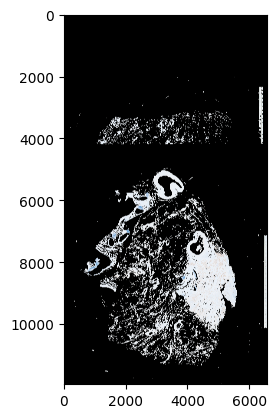

In [4]:
import matplotlib.pyplot as plt

plt.imshow(canvas)

# HES SAMPLE

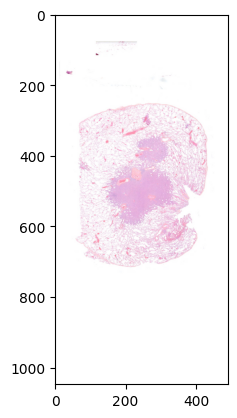

In [10]:
import openslide
import matplotlib.pyplot as plt
import cv2
# get thumbnail
HES_SLIDE_PATH = "D:/data/images/bloc/25P7216_6_1_HES.mrxs"
slide = openslide.OpenSlide(HES_SLIDE_PATH)
img =slide.get_thumbnail(tuple([1048,1048]))
plt.imshow(img)

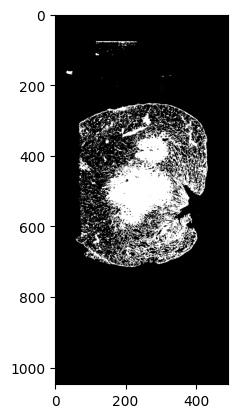

In [11]:


slide_array = np.array(img)
flattened = slide_array.reshape((-1, 3))

# convert to float 32
flattened = np.float32(flattened)

        # k means clustering
ret, label, center = cv2.kmeans(flattened, 2, None
, (cv2.TERM_CRITERIA_MAX_ITER + cv2.TERM_CRITERIA_EPS, 10, 1)
, 10, cv2.KMEANS_RANDOM_CENTERS)
# convert back to unint8 and assemble image
center = np.uint8(center)
res = center[label.flatten()]
res2 = res.reshape((slide_array.shape))

# center shape: (3, 3) -> RGB centers
brightness = center.sum(axis=1)

# index of whitest cluster
white_cluster = np.argmax(brightness)
labels_2d = label.reshape(slide_array.shape[:2])
white_mask = (labels_2d == white_cluster)
# Convert to RGBA
res2_rgba = np.dstack([res2, np.full(res2.shape[:2], 255, dtype=np.uint8)])
black_mask = ~white_mask



plt.imshow(black_mask, cmap='gray')

In [13]:
import os
import re
import numpy as np
from PIL import Image
from tqdm import tqdm

# -----------------------------
# PARAMETERS
# -----------------------------
PATCH_DIR = "D:/data/patching_HES_v0"
PATCH_SIZE = 224
DOWNSAMPLE = 16   # reduce memory (must divide PATCH_SIZE)

# -----------------------------
# PARSE PATCH METADATA
# -----------------------------
patch_regex = re.compile(
    r"x(\d+)_y(\d+)_patch_\d+_(.+)\.png"
)

patches = []

for fname in os.listdir(PATCH_DIR):
    match = patch_regex.match(fname)
    if match:
        x, y, wsi = match.groups()
        patches.append((int(x), int(y), fname))

if not patches:
    raise RuntimeError("No patches found.")

# -----------------------------
# COMPUTE GRID SIZE
# -----------------------------
xs = [p[0] for p in patches]
ys = [p[1] for p in patches]

max_x = max(xs)
max_y = max(ys)

grid_w = max_x // PATCH_SIZE + 1
grid_h = max_y // PATCH_SIZE + 1

thumb_patch_size = PATCH_SIZE // DOWNSAMPLE

# -----------------------------
# CREATE CANVAS
# -----------------------------
canvas = np.zeros(
    (grid_h * thumb_patch_size,
     grid_w * thumb_patch_size,
     3),
    dtype=np.uint8
)

# -----------------------------
# FILL SELECTED PATCHES
# -----------------------------
for x, y, fname in tqdm(patches):
    img = Image.open(os.path.join(PATCH_DIR, fname))
    img = img.resize(
        (thumb_patch_size, thumb_patch_size),
        Image.BILINEAR
    )

    gx = x // PATCH_SIZE
    gy = y // PATCH_SIZE

    canvas[
        gy * thumb_patch_size:(gy + 1) * thumb_patch_size,
        gx * thumb_patch_size:(gx + 1) * thumb_patch_size
    ] = np.array(img)



100%|██████████| 21047/21047 [03:48<00:00, 92.15it/s] 


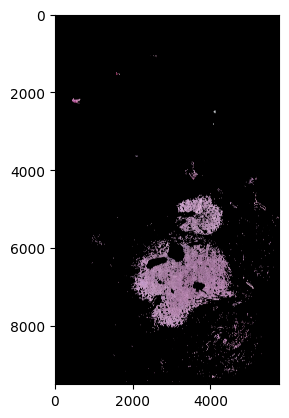

In [14]:
import matplotlib.pyplot as plt

plt.imshow(canvas)

In [17]:
#Image Reconstruction for HER2MATCH

import os
import re
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

# -----------------------------
# PARAMETERS
# -----------------------------
PATCH_DIR = "D:/data/HER2Match/HE/test/"
OUTPUT_PATH = "wsi001_thumbnail.png"

WSI_NAME = "wsi001"
PATCH_SIZE = 1024
DOWNSAMPLE = 16   # thumbnail factor (1024 / 16 = 64 px per patch)

# -----------------------------
# REGEX FOR FILENAMES
# -----------------------------
pattern = re.compile(
    rf"{WSI_NAME}_.*_x(\d+)_y(\d+)\.jpg"
)

patches = []

for fname in os.listdir(PATCH_DIR):
    match = pattern.match(fname)
    if match:
        x, y = map(int, match.groups())
        patches.append((x, y, fname))

if not patches:
    raise RuntimeError(f"No patches found for {WSI_NAME}")

# -----------------------------
# COMPUTE GRID SIZE
# -----------------------------
xs = [p[0] for p in patches]
ys = [p[1] for p in patches]

max_x = max(xs)
max_y = max(ys)

grid_w = max_x // PATCH_SIZE + 1
grid_h = max_y // PATCH_SIZE + 1

thumb_patch_size = PATCH_SIZE // DOWNSAMPLE

# -----------------------------
# CREATE CANVAS (black background)
# -----------------------------
canvas = np.zeros(
    (grid_h * thumb_patch_size,
     grid_w * thumb_patch_size,
     3),
    dtype=np.uint8
)

# -----------------------------
# FILL PATCHES
# -----------------------------
for x, y, fname in tqdm(patches, desc="Reconstructing"):
    img = Image.open(os.path.join(PATCH_DIR, fname))
    img = img.resize(
        (thumb_patch_size, thumb_patch_size),
        Image.BILINEAR
    )

    gx = x // PATCH_SIZE
    gy = y // PATCH_SIZE

    canvas[
        gy * thumb_patch_size:(gy + 1) * thumb_patch_size,
        gx * thumb_patch_size:(gx + 1) * thumb_patch_size
    ] = np.array(img)




Reconstructing: 100%|██████████| 1505/1505 [00:28<00:00, 53.11it/s]


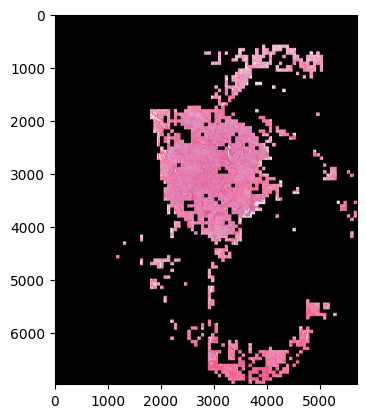

In [18]:
canvas_hes = canvas
plt.imshow(canvas_hes)

In [19]:
# Same Thing for IHC
import os
import re
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

# -----------------------------
# PARAMETERS
# -----------------------------
PATCH_DIR = "D:/data/HER2Match/IHC/test/"
OUTPUT_PATH = "wsi001_thumbnail.png"

WSI_NAME = "wsi001"
PATCH_SIZE = 1024
DOWNSAMPLE = 16   # thumbnail factor (1024 / 16 = 64 px per patch)

# -----------------------------
# REGEX FOR FILENAMES
# -----------------------------
pattern = re.compile(
    rf"{WSI_NAME}_.*_x(\d+)_y(\d+)\.jpg"
)

patches = []

for fname in os.listdir(PATCH_DIR):
    match = pattern.match(fname)
    if match:
        x, y = map(int, match.groups())
        patches.append((x, y, fname))

if not patches:
    raise RuntimeError(f"No patches found for {WSI_NAME}")

# -----------------------------
# COMPUTE GRID SIZE
# -----------------------------
xs = [p[0] for p in patches]
ys = [p[1] for p in patches]

max_x = max(xs)
max_y = max(ys)

grid_w = max_x // PATCH_SIZE + 1
grid_h = max_y // PATCH_SIZE + 1

thumb_patch_size = PATCH_SIZE // DOWNSAMPLE

# -----------------------------
# CREATE CANVAS (black background)
# -----------------------------
canvas = np.zeros(
    (grid_h * thumb_patch_size,
     grid_w * thumb_patch_size,
     3),
    dtype=np.uint8
)

# -----------------------------
# FILL PATCHES
# -----------------------------
for x, y, fname in tqdm(patches, desc="Reconstructing"):
    img = Image.open(os.path.join(PATCH_DIR, fname))
    img = img.resize(
        (thumb_patch_size, thumb_patch_size),
        Image.BILINEAR
    )

    gx = x // PATCH_SIZE
    gy = y // PATCH_SIZE

    canvas[
        gy * thumb_patch_size:(gy + 1) * thumb_patch_size,
        gx * thumb_patch_size:(gx + 1) * thumb_patch_size
    ] = np.array(img)

Reconstructing: 100%|██████████| 1505/1505 [00:31<00:00, 48.29it/s]


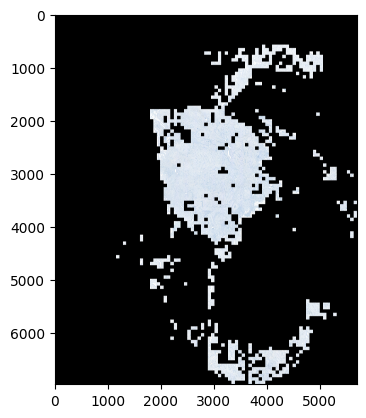

In [20]:
canvas_ihc = canvas
plt.imshow(canvas_ihc)

In [ ]:

import os
import re
import numpy as np
from PIL import Image
from tqdm import tqdm

# -----------------------------
# PARAMETERS
# -----------------------------
PATCH_DIR = "D:/data/patching_HES_v0"
PATCH_SIZE = 224
DOWNSAMPLE = 16   # reduce memory (must divide PATCH_SIZE)

# -----------------------------
# PARSE PATCH METADATA
# -----------------------------
patch_regex = re.compile(
    r"x(\d+)_y(\d+)_patch_\d+_(.+)\.png"
)

patches = []

for fname in os.listdir(PATCH_DIR):
    match = patch_regex.match(fname)
    if match:
        x, y, wsi = match.groups()
        patches.append((int(x), int(y), fname))

if not patches:
    raise RuntimeError("No patches found.")

# -----------------------------
# COMPUTE GRID SIZE
# -----------------------------
xs = [p[0] for p in patches]
ys = [p[1] for p in patches]

max_x = max(xs)
max_y = max(ys)

grid_w = max_x // PATCH_SIZE + 1
grid_h = max_y // PATCH_SIZE + 1

thumb_patch_size = PATCH_SIZE // DOWNSAMPLE

# -----------------------------
# CREATE CANVAS
# -----------------------------
canvas = np.zeros(
    (grid_h * thumb_patch_size,
     grid_w * thumb_patch_size,
     3),
    dtype=np.uint8
)

# -----------------------------
# FILL SELECTED PATCHES
# -----------------------------
for x, y, fname in tqdm(patches):
    img = Image.open(os.path.join(PATCH_DIR, fname))
    img = img.resize(
        (thumb_patch_size, thumb_patch_size),
        Image.BILINEAR
    )

    gx = x // PATCH_SIZE
    gy = y // PATCH_SIZE

    canvas[
        gy * thumb_patch_size:(gy + 1) * thumb_patch_size,
        gx * thumb_patch_size:(gx + 1) * thumb_patch_size
    ] = np.array(img)